In [1]:
##https://www.kaggle.com/neelkudu28/covid-19-data-analysis-forecasting-for-india
## conda install -c conda-forge fbprophet
import requests, pandas as pd, numpy as np
from pandas import DataFrame
from io import StringIO
import time, json
from datetime import date
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 20

In [2]:
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import datetime as dt
from datetime import timedelta
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.api as sm
from fbprophet import Prophet

In [4]:
covid=pd.read_csv("covid_19_data.csv")
covid.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [6]:
#Extracting India's data 
covid_india=covid[covid['Country/Region']=="India"]
covid_india.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
430,431,01/30/2020,NaN,India,1/30/20 16:00,1.0,0.0,0.0
491,492,01/31/2020,NaN,India,1/31/2020 23:59,1.0,0.0,0.0
547,548,02/01/2020,NaN,India,1/31/2020 8:15,1.0,0.0,0.0
607,608,02/02/2020,NaN,India,2020-02-02T06:03:08,2.0,0.0,0.0
672,673,02/03/2020,NaN,India,2020-02-03T21:43:02,3.0,0.0,0.0


In [8]:
#Converting the date into Datetime format
covid_india["ObservationDate"]=pd.to_datetime(covid_india["ObservationDate"])
covid_india.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
430,431,2020-01-30,NaN,India,1/30/20 16:00,1.0,0.0,0.0
491,492,2020-01-31,NaN,India,1/31/2020 23:59,1.0,0.0,0.0
547,548,2020-02-01,NaN,India,1/31/2020 8:15,1.0,0.0,0.0
607,608,2020-02-02,NaN,India,2020-02-02T06:03:08,2.0,0.0,0.0
672,673,2020-02-03,NaN,India,2020-02-03T21:43:02,3.0,0.0,0.0


In [10]:
#Grouping the data based on the Date 
india_datewise=covid_india.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
india_datewise.head()

,Confirmed,Recovered,Deaths
ObservationDate,,,
2020-01-30,1.0,0.0,0.0
2020-01-31,1.0,0.0,0.0
2020-02-01,1.0,0.0,0.0
2020-02-02,2.0,0.0,0.0
2020-02-03,3.0,0.0,0.0


In [11]:
#Adding week column to perfom weekly analysis further ahead
india_datewise["WeekofYear"]=india_datewise.index.weekofyear

In [12]:
#Adding week column to perfom weekly analysis further ahead
india_datewise["WeekofYear"]=india_datewise.index.weekofyear

In [13]:
india_datewise["Days Since"]=(india_datewise.index-india_datewise.index[0])
india_datewise["Days Since"]=india_datewise["Days Since"].dt.days

In [14]:
print("Number of Confirmed Cases",india_datewise["Confirmed"].iloc[-1])
print("Number of Recovered Cases",india_datewise["Recovered"].iloc[-1])
print("Number of Death Cases",india_datewise["Deaths"].iloc[-1])
print("Number of Active Cases",india_datewise["Confirmed"].iloc[-1]-india_datewise["Recovered"].iloc[-1]
                                                                   -india_datewise["Deaths"].iloc[-1])
print("Number of Closed Cases",india_datewise["Recovered"].iloc[-1]+india_datewise["Deaths"].iloc[-1])
print("Approximate Number of Confirmed Cases per day",round(india_datewise["Confirmed"].iloc[-1]/india_datewise.shape[0]))
print("Approximate Number of Recovered Cases per day",round(india_datewise["Recovered"].iloc[-1]/india_datewise.shape[0]))
print("Approximate Number of Death Cases per day",round(india_datewise["Deaths"].iloc[-1]/india_datewise.shape[0]))
print("Number of New Cofirmed Cases in last 24 hours are",india_datewise["Confirmed"].iloc[-1]
                                                                   -india_datewise["Confirmed"].iloc[-2])
print("Number of New Recoverd Cases in last 24 hours are",india_datewise["Recovered"].iloc[-1]
                                                                   -india_datewise["Recovered"].iloc[-2])
print("Number of New Death Cases in last 24 hours are",india_datewise["Deaths"].iloc[-1]
                                                                    -india_datewise["Deaths"].iloc[-2])

Number of Confirmed Cases 37257.0
Number of Recovered Cases 10007.0
Number of Death Cases 1223.0
Number of Active Cases 26027.0
Number of Closed Cases 11230.0
Approximate Number of Confirmed Cases per day 401.0
Approximate Number of Recovered Cases per day 108.0
Approximate Number of Death Cases per day 13.0
Number of New Cofirmed Cases in last 24 hours are 2394.0
Number of New Recoverd Cases in last 24 hours are 939.0
Number of New Death Cases in last 24 hours are 69.0


Text(0.5, 1.0, 'Distribution of Number of Active Cases in India over Date')

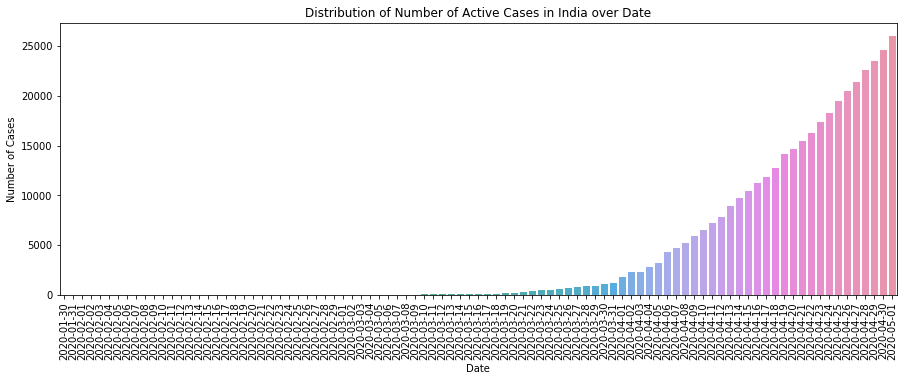

In [14]:
plt.figure(figsize=(15,5))
sns.barplot(x=india_datewise.index.date,y=india_datewise["Confirmed"]-india_datewise["Recovered"]-india_datewise["Deaths"])
plt.xticks(rotation=90)
plt.ylabel("Number of Cases")
plt.xlabel("Date")
plt.title("Distribution of Number of Active Cases in India over Date")

Text(0.5, 1.0, 'Distribution of Number of Closed Cases in India over Date')

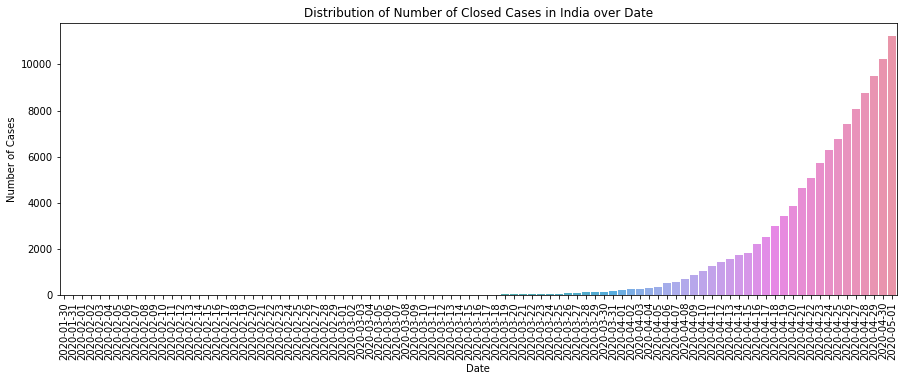

In [15]:
plt.figure(figsize=(15,5))
sns.barplot(x=india_datewise.index.date,y=india_datewise["Recovered"]+india_datewise["Deaths"])
plt.xticks(rotation=90)
plt.ylabel("Number of Cases")
plt.xlabel("Date")
plt.title("Distribution of Number of Closed Cases in India over Date")

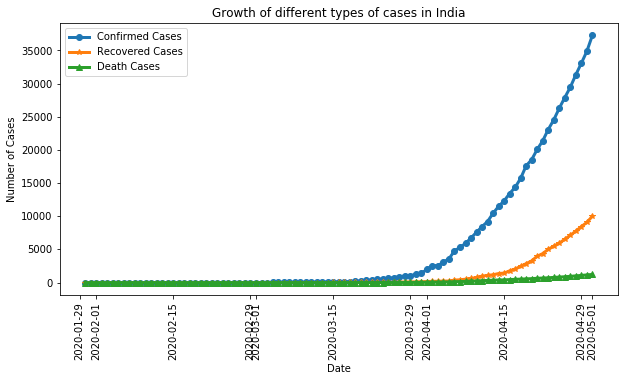

In [19]:
plt.figure(figsize=(10,5))
plt.plot(india_datewise["Confirmed"],label="Confirmed Cases",marker='o',linewidth=3)
plt.plot(india_datewise["Recovered"],label="Recovered Cases",marker='*',linewidth=3)
plt.plot(india_datewise["Deaths"],label="Death Cases",marker="^",linewidth=3)
plt.xticks(rotation=90)
plt.ylabel("Number of Cases")
plt.xlabel("Date")
plt.title("Growth of different types of cases in India")
plt.legend()

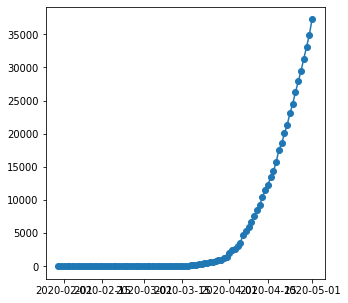

In [22]:
plt.rcParams['figure.figsize'] = 5, 5
plt.plot(india_datewise["Confirmed"],marker='o')

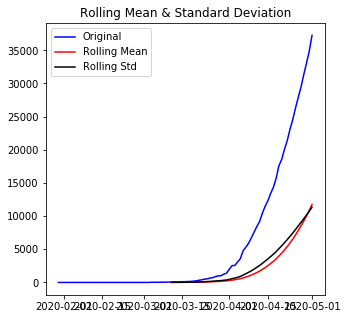

Results of Dickey-Fuller Test:
Test Statistic                 -0.154594
p-value                         0.943722
#Lags Used                     12.000000
Number of Observations Used    80.000000
Critical Value (1%)            -3.514869
Critical Value (5%)            -2.898409
Critical Value (10%)           -2.586439
dtype: float64


In [24]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rcParams['figure.figsize'] = 5, 5
    rolmean = timeseries.rolling(window=42,center=False).mean() 
    rolstd = timeseries.rolling(window=42,center=False).std()
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
            'p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
ts_month=india_datewise["Confirmed"]    
test_stationarity(ts_month)

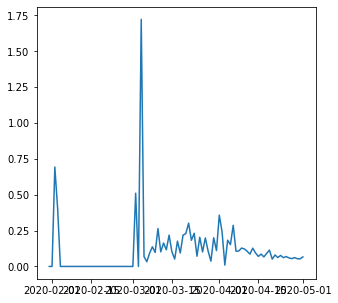

In [25]:
ts_month_log = np.log(ts_month)
ts_month_log_diff = ts_month_log - ts_month_log.shift()
plt.plot(ts_month_log_diff)

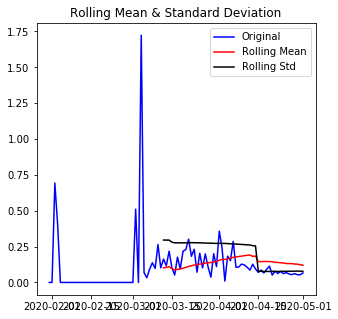

Results of Dickey-Fuller Test:
Test Statistic                 -5.393147
p-value                         0.000004
#Lags Used                      1.000000
Number of Observations Used    90.000000
Critical Value (1%)            -3.505190
Critical Value (5%)            -2.894232
Critical Value (10%)           -2.584210
dtype: float64


In [26]:
ts_month_log_diff.dropna(inplace=True)
test_stationarity(ts_month_log_diff)

In [27]:
#ACF and PACF



Text(0.5, 1.0, 'Autocorrelation Function')

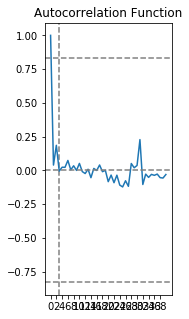

In [49]:
lag_acf = acf(ts_month_log_diff)
#Plot ACF: 
plt.subplot(121)
plt.rcParams['figure.figsize'] = 5, 5
plt.xticks(np.arange(0, 40,2))
plt.axvline(x=3,linestyle='--',color='gray')
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_month_log_diff))
            ,linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_month_log_diff))
            ,linestyle='--',color='gray')
plt.title('Autocorrelation Function')

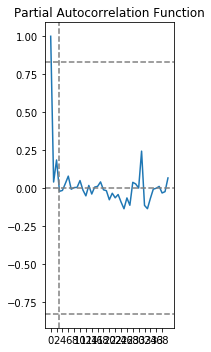

In [29]:
lag_pacf = pacf(ts_month_log_diff, method='ols')
#Plot PACF:
plt.subplot(122)
plt.rcParams['figure.figsize'] = 5, 5
plt.plot(lag_pacf)
plt.xticks(np.arange(0, 40,2))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axvline(x=3,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_month_log_diff))
            ,linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_month_log_diff))
            ,linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [30]:
size = int(len(ts_month_log) - 5)
train, test = ts_month_log[0:size], ts_month_log[size:len(ts_month_log)]
history = [x for x in train]
predictions = list()
print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(history, order=(3,1,3))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))

Printing Predicted vs Expected Values...


predicted=38502.817445, expected=37257.000000


In [31]:
o2=model_fit.forecast()
np.exp(o2[0])

array([38502.81744541])

In [114]:
predictions

[10.34049381280679,
 10.393853108876815,
 10.452567950237224,
 10.506701650974314,
 10.5584866979987]

In [115]:
z1

,Pred
0,30961.315367
1,32658.260652
2,34633.196941
3,36559.693826
4,38502.817445


In [116]:
india_datewise.tail(16)

,Confirmed,Recovered,Deaths,WeekofYear,Days Since
ObservationDate,,,,,
2020-04-16,13430.0,1768.0,448.0,16,77
2020-04-17,14352.0,2041.0,486.0,16,78
2020-04-18,15722.0,2463.0,521.0,16,79
2020-04-19,17615.0,2854.0,559.0,16,80
2020-04-20,18539.0,3273.0,592.0,17,81
2020-04-21,20080.0,3975.0,645.0,17,82
2020-04-22,21370.0,4370.0,681.0,17,83
2020-04-23,23077.0,5012.0,721.0,17,84
2020-04-24,24530.0,5498.0,780.0,17,85


In [33]:
didx = pd.DatetimeIndex(start ='2020-04-28', freq ='D',periods = len(z1))
didx

DatetimeIndex(['2020-04-28', '2020-04-29', '2020-04-30', '2020-05-01',
               '2020-05-02'],
              dtype='datetime64[ns]', freq='D')

In [34]:
z1=pd.DataFrame({'Pred':predictions}).apply(np.exp)
z1.index=didx
round(z1)

,Pred
2020-04-28,30961.0
2020-04-29,32658.0
2020-04-30,34633.0
2020-05-01,36560.0
2020-05-02,38503.0


In [35]:
error = mean_squared_error(test, predictions)
print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)
predictions_series = pd.Series(predictions, index = test.index)



Printing Mean Squared Error of Predictions...
Test MSE: 0.001947


(array([737456., 737470., 737485., 737499., 737516., 737530., 737546.]),
 <a list of 7 Text xticklabel objects>)

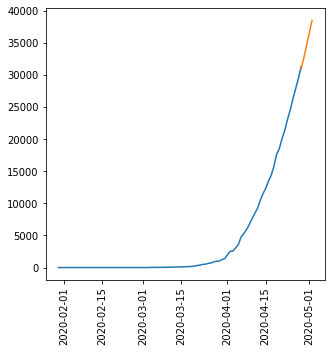

In [42]:
plt.plot(ts_month[:'2020-04-28'])
plt.rcParams['figure.figsize'] = 5, 5
plt.plot(z1)
plt.xticks(rotation=90)

In [111]:
model_train.tail(5)

,Confirmed,Recovered,Deaths,WeekofYear,Days Since
ObservationDate,,,,,
2020-04-22,21370.0,4370.0,681.0,17,83
2020-04-23,23077.0,5012.0,721.0,17,84
2020-04-24,24530.0,5498.0,780.0,17,85
2020-04-25,26283.0,5939.0,825.0,17,86
2020-04-26,27890.0,6523.0,881.0,17,87


In [105]:
y_pred

,Confirmed,Recovered,Deaths,WeekofYear,Days Since
ObservationDate,,,,,
2020-04-27,29451.0,7137.0,939.0,18,88
2020-04-28,31324.0,7747.0,1008.0,18,89
2020-04-29,33062.0,8437.0,1079.0,18,90
2020-04-30,34863.0,9068.0,1154.0,18,91
2020-05-01,37257.0,10007.0,1223.0,18,92


In [ ]:
model_train=india_datewise.iloc[:int(india_datewise.shape[0]*0.95)]
#model_train=india_datewise.iloc[:]
valid=india_datewise.iloc[int(india_datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [108]:
holt=Holt(np.asarray(model_train["Confirmed"])).fit(smoothing_level=0.4, smoothing_slope=1.7)

In [109]:
y_pred["Holt"]=holt.forecast(len(valid))
rmse_holt_linear=np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["Holt"]))
model_scores=[]
model_scores.append(rmse_holt_linear)
print("Root Mean Square Error Holt's Linear Model: ",rmse_holt_linear)

Root Mean Square Error Holt's Linear Model:  252.75944528927562


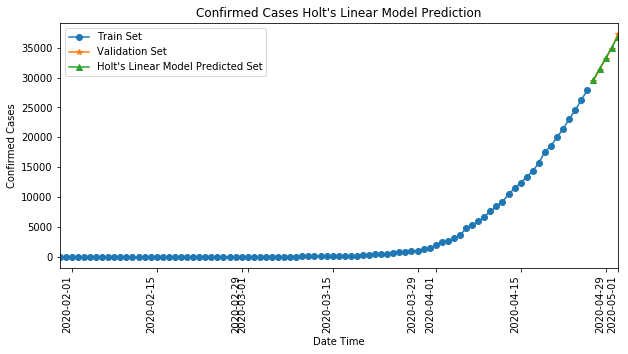

In [110]:
plt.figure(figsize=(10,5))
plt.plot(model_train.Confirmed,label="Train Set",marker='o')
valid.Confirmed.plot(label="Validation Set",marker='*')
y_pred.Holt.plot(label="Holt's Linear Model Predicted Set",marker='^')
plt.ylabel("Confirmed Cases")
plt.xlabel("Date Time")
plt.title("Confirmed Cases Holt's Linear Model Prediction")
plt.xticks(rotation=90)
plt.legend()

In [85]:
y_pred["Holt"]

ObservationDate
2020-04-27    29669.256140
2020-04-28    31456.186597
2020-04-29    33243.117054
2020-04-30    35030.047511
2020-05-01    36816.977968
Name: Holt, dtype: float64

In [ ]:
model_train=india_datewise.iloc[:len(india_datewise)-5]
valid=india_datewise.iloc[len(india_datewise)-5:]
y_pred=valid.copy()
holt=Holt(np.asarray(model_train["Confirmed"])).fit(smoothing_level=0.4, smoothing_slope=1.7)
y_pred["Holt"]=holt.forecast(len(valid))
rmse_holt_linear=np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["Holt"]))
model_scores=[]
model_scores.append(rmse_holt_linear)
print("Root Mean Square Error Holt's Linear Model: ",rmse_holt_linear)
plt.figure(figsize=(10,5))
plt.plot(model_train.Confirmed,label="Train Set",marker='o')
valid.Confirmed.plot(label="Validation Set",marker='*')
y_pred.Holt.plot(label="Holt's Linear Model Predicted Set",marker='^')
plt.ylabel("Confirmed Cases")
plt.xlabel("Date Time")
plt.title("Confirmed Cases Holt's Linear Model Prediction")
plt.xticks(rotation=90)
plt.legend()

In [86]:
valid

,Confirmed,Recovered,Deaths,WeekofYear,Days Since
ObservationDate,,,,,
2020-04-27,29451.0,7137.0,939.0,18,88
2020-04-28,31324.0,7747.0,1008.0,18,89
2020-04-29,33062.0,8437.0,1079.0,18,90
2020-04-30,34863.0,9068.0,1154.0,18,91
2020-05-01,37257.0,10007.0,1223.0,18,92


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Figure(720x432)


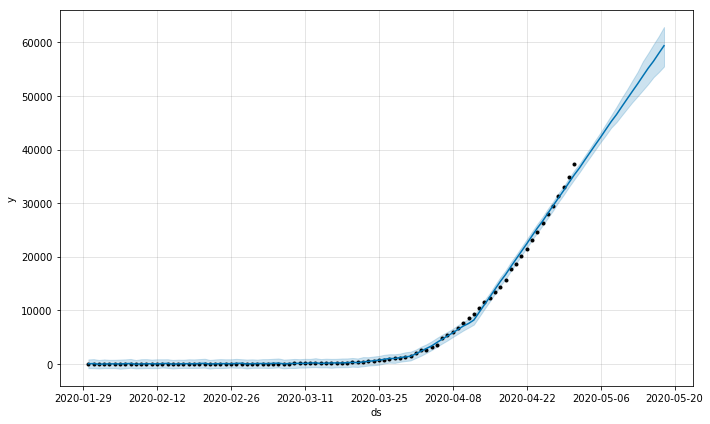

In [123]:
from fbprophet import Prophet
prophet_c=Prophet(interval_width=0.95,weekly_seasonality=True,)
prophet_confirmed=pd.DataFrame(zip(list(india_datewise.index),list(india_datewise["Confirmed"])),columns=['ds','y'])
prophet_c.fit(prophet_confirmed)
forecast_c=prophet_c.make_future_dataframe(periods=17)
forecast_confirmed=forecast_c.copy()
confirmed_forecast=prophet_c.predict(forecast_c)
print(prophet_c.plot(confirmed_forecast))